In [1]:
import pandas as pd

In [2]:
train_results_dir = 'results_GP_shipsnet_newslate'

In [3]:
import os

In [6]:
search_dir = 'results_GP_shipsnet_newslate'
#list all .json files in the directory
all_files = [f for f in os.listdir(search_dir)]
json_files = [f for f in os.listdir(search_dir) if f.endswith('.json')]

# excluding the format, get the last 16 characters of each filename
timestamps = [f[:-5][-16:] for f in json_files]
print("Timestamps found count:", len(timestamps))

# remove some timestamps that are not needed
# those are the ones that are not in the shipsnet_seu_result directory, without the .csv extension
#excluded_timestamps = [f[:-4][-16:] for f in [f for f in os.listdir('shipsnet_newslate_seu_result') if f.endswith('.csv')]]

#timestamps = [ts for ts in timestamps if ts not in excluded_timestamps]
#timestamps = timestamps[:1]
#print("After excluding, timestamps count:", len(timestamps))

Timestamps found count: 63


In [ ]:
config_files = {}
guide_files = {}
model_files = {}
param_files = {}

for timestamp in timestamps:
    config_files[timestamp] = [f for f in all_files if timestamp in f and f.endswith('.json')][0]
    guide_files[timestamp] = [f for f in all_files if timestamp in f and f.startswith('guide')][0]
    model_files[timestamp] = [f for f in all_files if timestamp in f and f.startswith('model')][0]
    param_files[timestamp] = [f for f in all_files if timestamp in f and f.startswith('param')][0]

In [10]:
ts_idx = 0

In [ ]:
import json

def load_model_config(timestamp):
    config_path = os.path.join(search_dir, config_files[timestamp])

    with open(config_path, 'r') as f:
        model_config = json.load(f)

    return model_config

In [12]:
model_config = load_model_config(timestamps[ts_idx])

In [13]:
model_config

{'activation': 'actRWG',
 'prior': 'gaussian',
 'num_epochs': 100,
 'best_accuracy_at_epoch': 1,
 'best_accuracy': 0.8546875,
 'batch_size': 16,
 'train_size': 3200,
 'prior_params': {'mu': 0.0, 'b': 10.0}}

## Distribution comparison

In [77]:
import torch
import torch.distributions as dist
import matplotlib.pyplot as plt

def plot_priors(mu, b, x_min=None, x_max=None, num_points=1000):
    """
    Plot the PDFs of three priors centered at mu with scale b:
      • Gaussian(μ, b)
      • Laplace(μ, b)
      • Uniform(–b, b)
    
    Parameters
    ----------
    mu : float
        Location parameter for Gaussian and Laplace.
    b : float
        Scale parameter for Gaussian and Laplace; half‐width for Uniform.
    x_min, x_max : float, optional
        Min/max of x‐axis. If None, they default to μ±5b.
    num_points : int
        Number of points to plot on the x‐axis.
    """
    # 1) Define the two torch distributions
    gaussian = dist.Normal(mu, b)
    laplace  = dist.Laplace(mu, b)

    # 2) Create x‐axis
    if x_min is None or x_max is None:
        x_min = mu - 5*b
        x_max = mu + 5*b
    x = torch.linspace(x_min, x_max, num_points)

    # 3) Compute PDFs
    p_gauss   = torch.exp(gaussian.log_prob(x))
    p_laplace = torch.exp(laplace.log_prob(x))
    # Manual Uniform PDF: 1/(2b) on [–b, b], else 0
    p_uniform = torch.where(
        (x >= mu - b) & (x <= mu + b),
        torch.tensor(1.0 / (2 * b)),
        torch.tensor(0.0)
    )

    # 4) Plot
    plt.figure(figsize=(8, 5))
    plt.plot(x.numpy(), p_gauss.numpy(),   label='Gaussian(μ, b)', color='blue')
    plt.plot(x.numpy(), p_laplace.numpy(), label='Laplace(μ, b)', color='orange')
    plt.plot(x.numpy(), p_uniform.numpy(), label='Uniform(μ±b)', color='green')
    plt.title(f'Prior PDFs (μ={mu}, b={b})')
    plt.xlabel('x')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


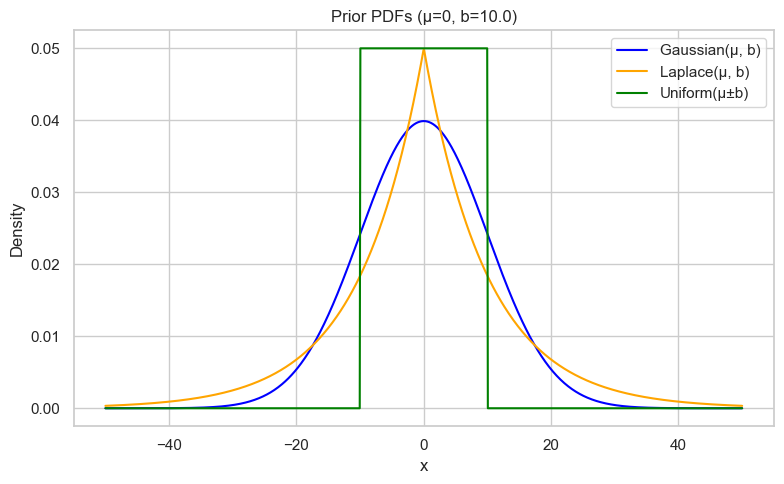

In [78]:
plot_priors(mu=0, b=10.0)

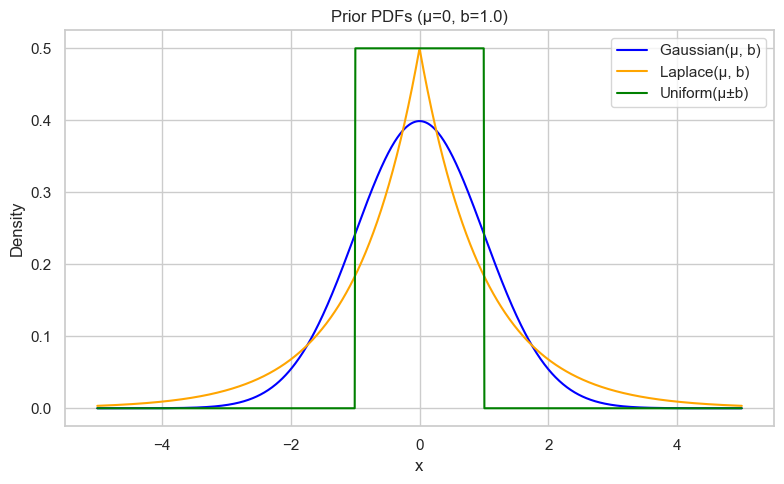

In [79]:
plot_priors(mu=0, b=1.0)

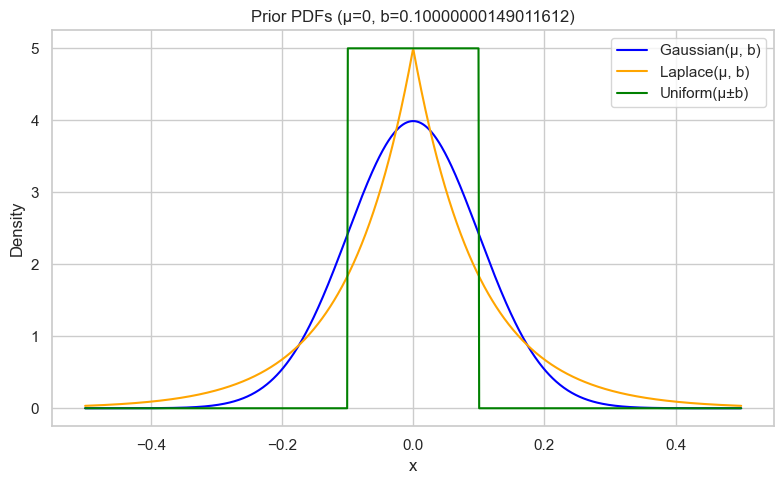

In [81]:
plot_priors(mu=0, b=0.10000000149011612)

## Train Accuracy Analysis

In [17]:
# loop through timestamps and load the model config
best_acc_df = pd.DataFrame(columns=['timestamp', 'activation', 'prior', 'best_acc', 'prior_mu', 'prior_b'])
for ts in timestamps:
    model_config = load_model_config(ts)

    # use pandas method of concat
    best_acc_df = pd.concat([best_acc_df, pd.DataFrame({
        'timestamp': [ts],
        'activation': [model_config['activation']],
        'prior': [model_config['prior']],
        'best_acc': [model_config['best_accuracy']],
        'prior_mu': [model_config['prior_params']['mu']],
        'prior_b': [model_config['prior_params']['b']]
    })], ignore_index=True)

C:\Users\Revalda Putawara\AppData\Local\Temp\ipykernel_19136\1128305422.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  best_acc_df = pd.concat([best_acc_df, pd.DataFrame({


In [18]:
best_acc_df

,timestamp,activation,prior,best_acc,prior_mu,prior_b
0,_20250717_030202,actRWG,gaussian,0.854688,0.0,10.0
1,_20250717_031000,actRWG,gaussian,0.852500,0.0,1.0
2,_20250717_031759,actRWG,gaussian,0.697187,0.0,0.1
3,_20250717_060336,actRWG,laplace,0.844063,0.0,10.0
4,_20250717_061243,actRWG,laplace,0.770625,0.0,1.0
...,...,...,...,...,...,...
58,_20250717_040050,tanh,laplace,0.796562,0.0,1.0
59,_20250717_040927,tanh,laplace,0.641563,0.0,0.1
60,_20250717_065848,tanh,uniform,0.870000,0.0,10.0
61,_20250717_070821,tanh,uniform,0.873750,0.0,1.0


In [23]:
best_acc_df.at[2, 'prior_b']

np.float64(0.10000000149011612)

In [ ]:
# for each prior_b, plot all combination of activation and prior in a histogram
# invert the plot so that the x-axis is the best_acc and the y-axis is the activation and prior
# use the blue color scheme

def plot_prior_b_histogram(df, prior_b_value):
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Filter the DataFrame for the specific prior_b value
    filtered_df = df[df['prior_b'] == prior_b_value]

    # Create a pivot table for plotting
    pivot_df = filtered_df.pivot_table(index='activation', columns='prior', values='best_acc', aggfunc='mean')

    # Plotting
    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot_df, annot=True, cmap='Blues', cbar_kws={'label': 'Best Accuracy'})
    plt.title(f'Best Train Accuracy for Prior b = {prior_b_value}')
    plt.xlabel('Prior')
    plt.ylabel('Activation')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

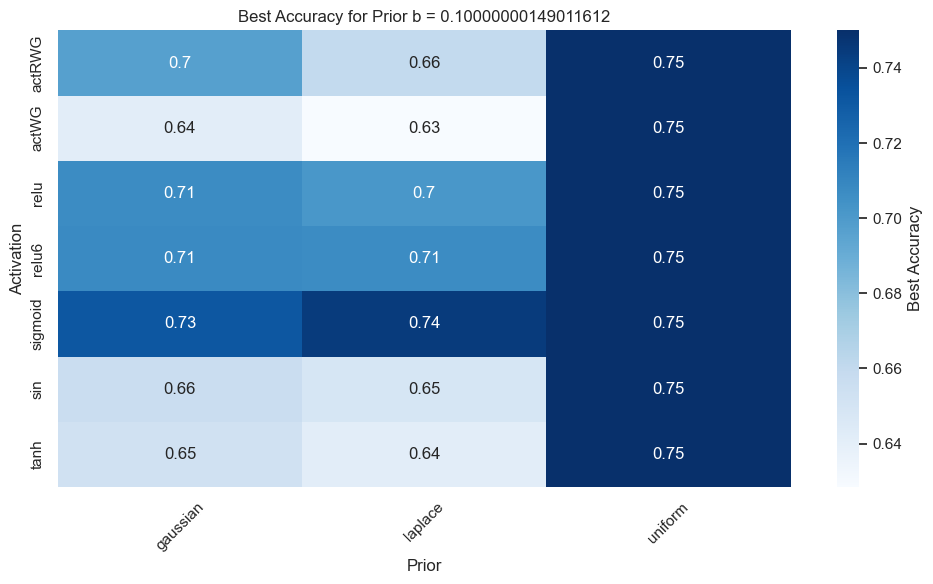

In [33]:
plot_prior_b_histogram(best_acc_df, 0.10000000149011612)

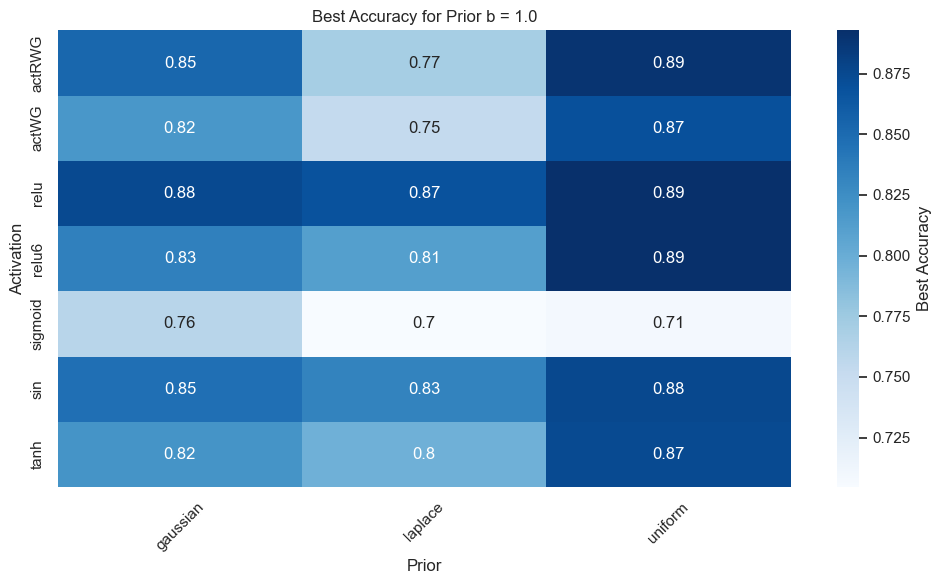

In [34]:
plot_prior_b_histogram(best_acc_df, 1.0)

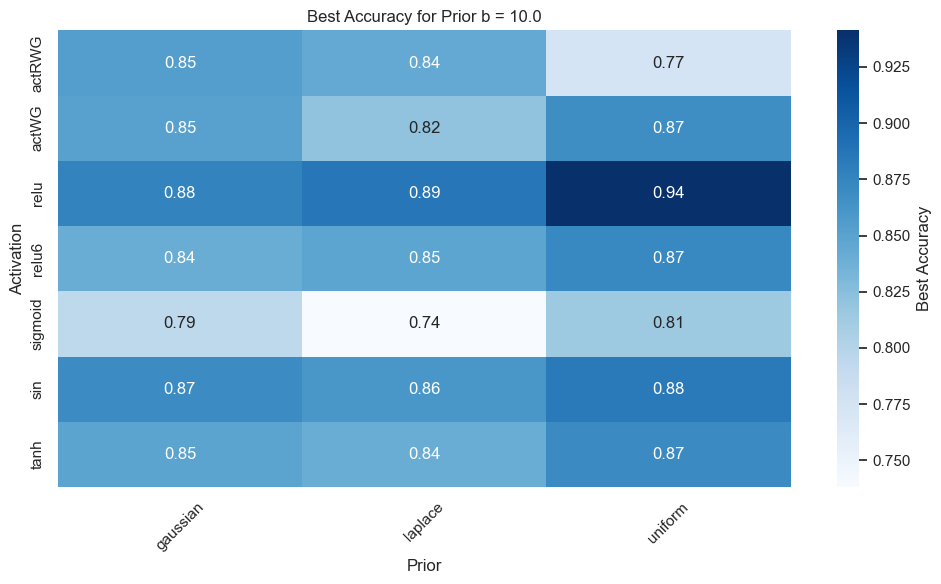

In [35]:
plot_prior_b_histogram(best_acc_df, 10.0)

From the results above, we can conclude that:
- uniform seemingly performs better in training across all b value (might be counterintuitive compared to what we believe in)

## Test Accuracy Analysis

In [41]:
# grab the csv files from the shipsnet_newslate_seu_result directory for 
prediction_files = {}

for timestamp in timestamps:
    prediction_files[timestamp] = [f for f in all_files if timestamp in f and f.endswith('.csv') and f.startswith('predictions')][0]

In [42]:
from sklearn.metrics import accuracy_score

In [44]:
best_test_acc_df = pd.DataFrame(columns=['timestamp', 'activation', 'prior', 'best_test_acc', 'prior_mu', 'prior_b'])

for ts in timestamps:
    model_config = load_model_config(ts)

    # Load the predictions
    pred_path = os.path.join('results_GP_shipsnet_newslate', prediction_files[ts])
    predictions = pd.read_csv(pred_path)

    # Calculate the accuracy
    y_true = predictions['True Label']
    y_pred = predictions['Predicted Label']
    best_test_acc = accuracy_score(y_true, y_pred)

    # Append to the DataFrame
    best_test_acc_df = pd.concat([best_test_acc_df, pd.DataFrame({
        'timestamp': [ts],
        'activation': [model_config['activation']],
        'prior': [model_config['prior']],
        'best_test_acc': [best_test_acc],
        'prior_mu': [model_config['prior_params']['mu']],
        'prior_b': [model_config['prior_params']['b']]
    })], ignore_index=True)

C:\Users\Revalda Putawara\AppData\Local\Temp\ipykernel_19136\3867051029.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  best_test_acc_df = pd.concat([best_test_acc_df, pd.DataFrame({


In [45]:
best_test_acc_df

,timestamp,activation,prior,best_test_acc,prior_mu,prior_b
0,_20250717_030202,actRWG,gaussian,0.75000,0.0,10.0
1,_20250717_031000,actRWG,gaussian,0.75375,0.0,1.0
2,_20250717_031759,actRWG,gaussian,0.75000,0.0,0.1
3,_20250717_060336,actRWG,laplace,0.75500,0.0,10.0
4,_20250717_061243,actRWG,laplace,0.76000,0.0,1.0
...,...,...,...,...,...,...
58,_20250717_040050,tanh,laplace,0.90000,0.0,1.0
59,_20250717_040927,tanh,laplace,0.75000,0.0,0.1
60,_20250717_065848,tanh,uniform,0.93000,0.0,10.0
61,_20250717_070821,tanh,uniform,0.88125,0.0,1.0


In [48]:
#join the two dataframes on timestamp, activation, prior, prior_mu, and prior_b
merged_df = pd.merge(best_acc_df, best_test_acc_df, on=['timestamp', 'activation', 'prior', 'prior_mu', 'prior_b'], suffixes=('_train', '_test'))
merged_df["best_acc_diff"] = merged_df["best_acc"] - merged_df["best_test_acc"]
merged_df

,timestamp,activation,prior,best_acc,prior_mu,prior_b,best_test_acc,best_acc_diff
0,_20250717_030202,actRWG,gaussian,0.854688,0.0,10.0,0.75000,0.104688
1,_20250717_031000,actRWG,gaussian,0.852500,0.0,1.0,0.75375,0.098750
2,_20250717_031759,actRWG,gaussian,0.697187,0.0,0.1,0.75000,-0.052813
3,_20250717_060336,actRWG,laplace,0.844063,0.0,10.0,0.75500,0.089063
4,_20250717_061243,actRWG,laplace,0.770625,0.0,1.0,0.76000,0.010625
...,...,...,...,...,...,...,...,...
58,_20250717_040050,tanh,laplace,0.796562,0.0,1.0,0.90000,-0.103438
59,_20250717_040927,tanh,laplace,0.641563,0.0,0.1,0.75000,-0.108437
60,_20250717_065848,tanh,uniform,0.870000,0.0,10.0,0.93000,-0.060000
61,_20250717_070821,tanh,uniform,0.873750,0.0,1.0,0.88125,-0.007500


In [ ]:
def plot_prior_b_histogram_test(df, prior_b_value):
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Filter the DataFrame for the specific prior_b value
    filtered_df = df[df['prior_b'] == prior_b_value]

    # Create a pivot table for plotting
    pivot_df = filtered_df.pivot_table(index='activation', columns='prior', values='best_acc', aggfunc='mean')

    # Plotting
    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot_df, annot=True, cmap='Blues', cbar_kws={'label': 'Best Accuracy'})
    plt.title(f'Test Accuracy for Prior b = {prior_b_value}')
    plt.xlabel('Prior')
    plt.ylabel('Activation')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

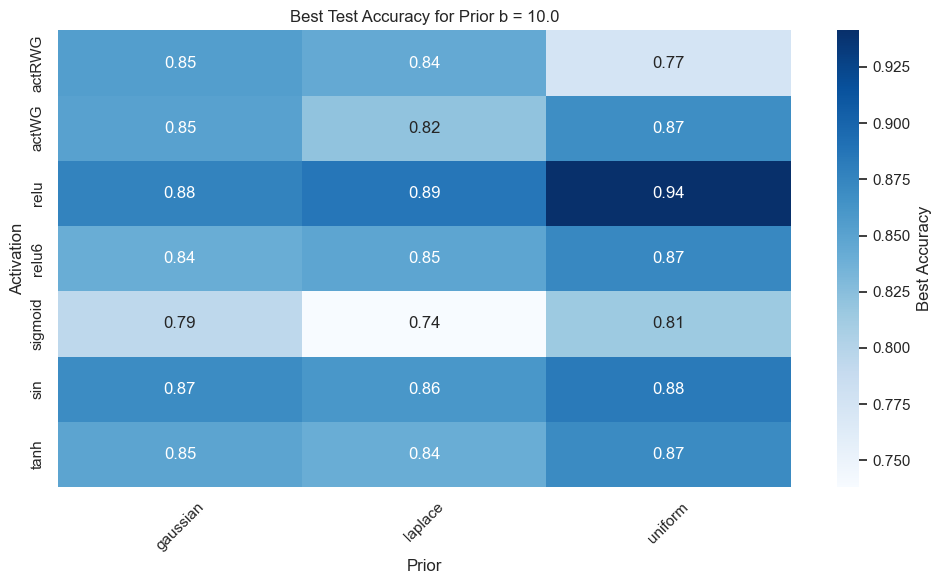

In [50]:
plot_prior_b_histogram_test(merged_df, 10.0)

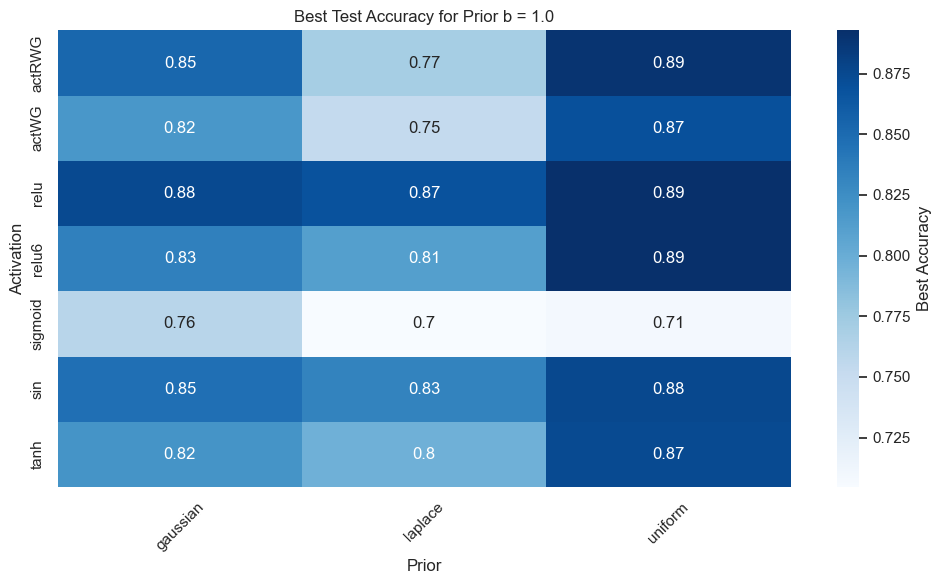

In [51]:
plot_prior_b_histogram_test(merged_df, 1.0)

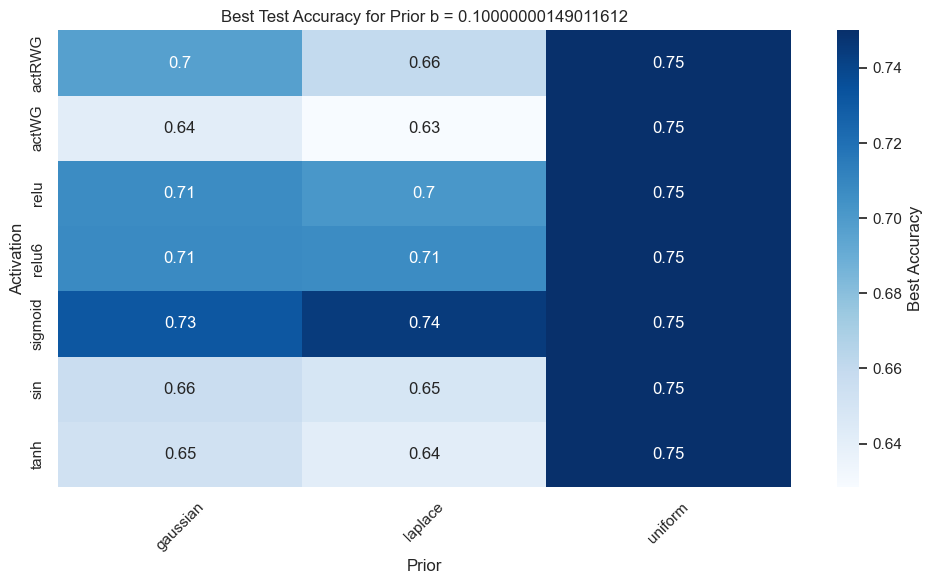

In [52]:
plot_prior_b_histogram_test(merged_df, 0.10000000149011612)

From the plots above, we can conclude that:
- uniform consistently better in test accuracy

## Train - Test Accuracy Differenve Analysis

In [67]:
# same as above, but plot for the difference between best_acc and best_test_acc
# give a color scale of red if it went to minus, blue if it went to plus
import matplotlib.pyplot as plt
import seaborn as sns


def plot_prior_b_histogram_diff(df, prior_b_value):
    # Filter the DataFrame for the specific prior_b value
    filtered_df = df[df['prior_b'] == prior_b_value]

    # Create a pivot table for plotting
    pivot_df = filtered_df.pivot_table(index='activation', columns='prior', values='best_acc_diff', aggfunc='mean')

    # Plotting
    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot_df, annot=True, cmap='coolwarm_r', center=0, cbar_kws={'label': 'Best Accuracy Difference'})
    plt.title(f'Best Accuracy Difference for Prior b = {prior_b_value}')
    plt.xlabel('Prior')
    plt.ylabel('Activation')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

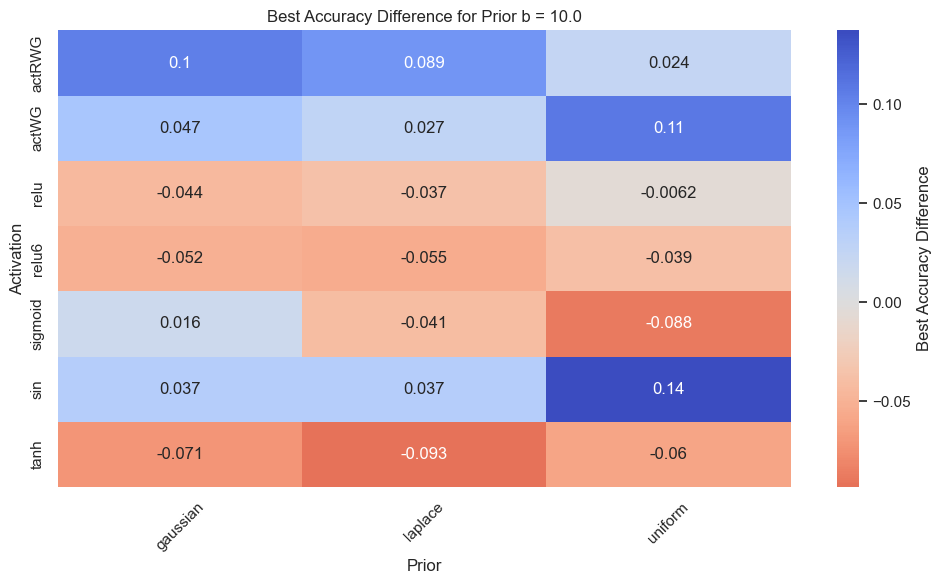

In [68]:
plot_prior_b_histogram_diff(merged_df, 10.0)

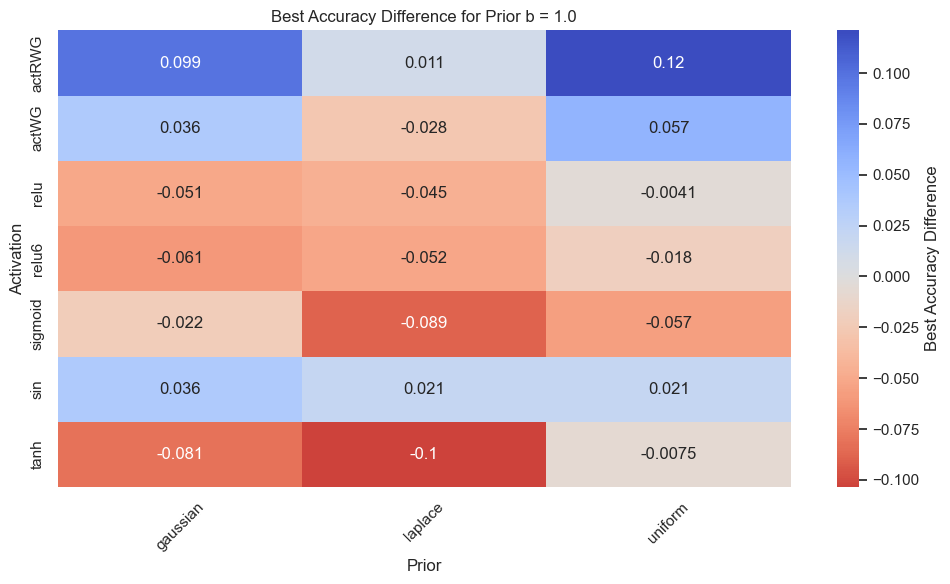

In [69]:
plot_prior_b_histogram_diff(merged_df, 1.0)

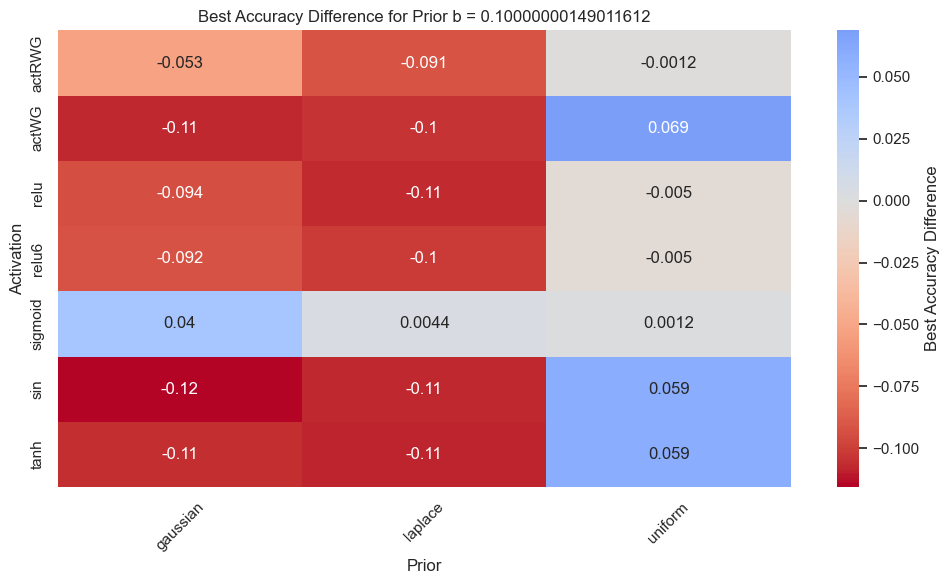

In [70]:
plot_prior_b_histogram_diff(merged_df, 0.10000000149011612)

In [82]:
# for uniform 0.1, get the confusion matrix

from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [84]:
merged_df

,timestamp,activation,prior,best_acc,prior_mu,prior_b,best_test_acc,best_acc_diff
0,_20250717_030202,actRWG,gaussian,0.854688,0.0,10.0,0.75000,0.104688
1,_20250717_031000,actRWG,gaussian,0.852500,0.0,1.0,0.75375,0.098750
2,_20250717_031759,actRWG,gaussian,0.697187,0.0,0.1,0.75000,-0.052813
3,_20250717_060336,actRWG,laplace,0.844063,0.0,10.0,0.75500,0.089063
4,_20250717_061243,actRWG,laplace,0.770625,0.0,1.0,0.76000,0.010625
...,...,...,...,...,...,...,...,...
58,_20250717_040050,tanh,laplace,0.796562,0.0,1.0,0.90000,-0.103438
59,_20250717_040927,tanh,laplace,0.641563,0.0,0.1,0.75000,-0.108437
60,_20250717_065848,tanh,uniform,0.870000,0.0,10.0,0.93000,-0.060000
61,_20250717_070821,tanh,uniform,0.873750,0.0,1.0,0.88125,-0.007500


In [104]:
#predictions = pd.read_csv(os.path.join('results_GP_shipsnet_newslate', prediction_files[timestamps[2]]))

#get the predictions object by filtering the timestamp from merged_df based on prior_b and activation
def show_cf_matrix(prior_b, prior, activation):

    target_timestmap = merged_df[
        (merged_df['prior_b'] == prior_b) & 
        (merged_df['prior'] == prior) &
        (merged_df['activation'] == activation)
    ].iloc[0, 0]

    predictions = pd.read_csv(os.path.join('results_GP_shipsnet_newslate', prediction_files[target_timestmap]))

    plot_confusion_matrix(y_true=predictions['True Label'], 
                        y_pred=predictions['Predicted Label'], 
                        title=f'Confusion Matrix for {activation} {prior} {prior_b:.2f} Prior')

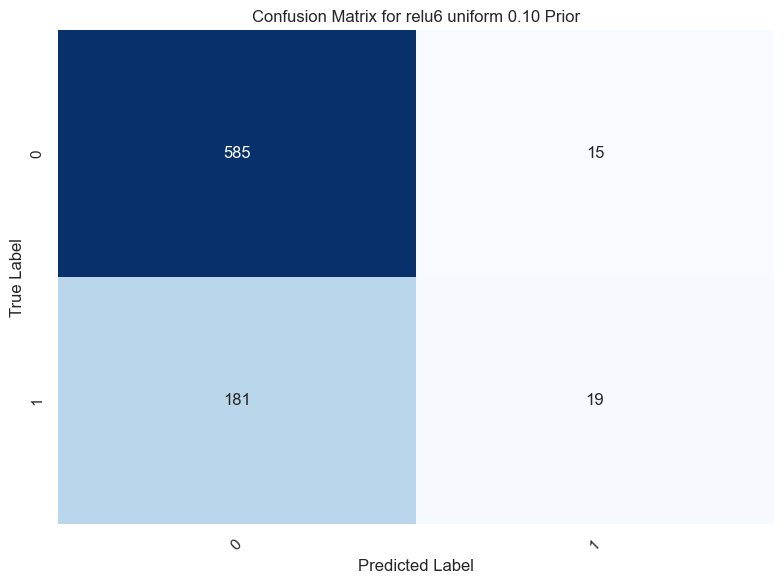

In [105]:
show_cf_matrix(0.10000000149011612, 'uniform', 'relu6')

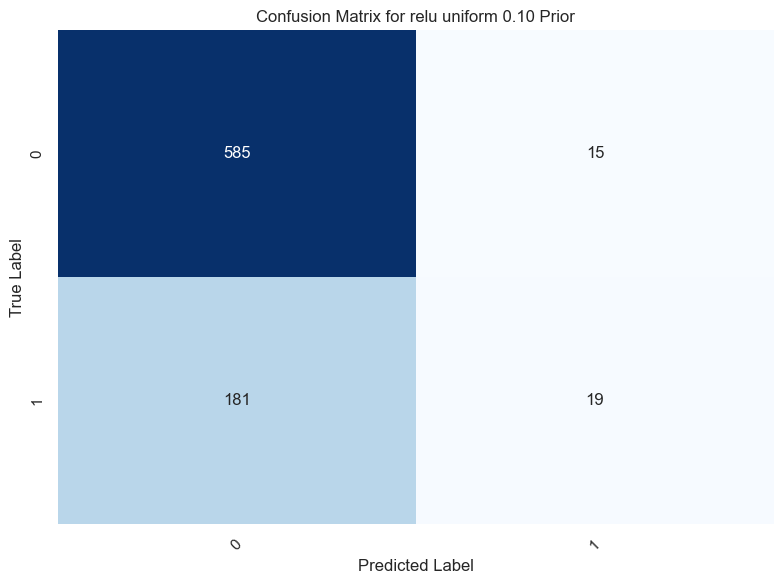

In [106]:
show_cf_matrix(0.10000000149011612, 'uniform', 'relu')

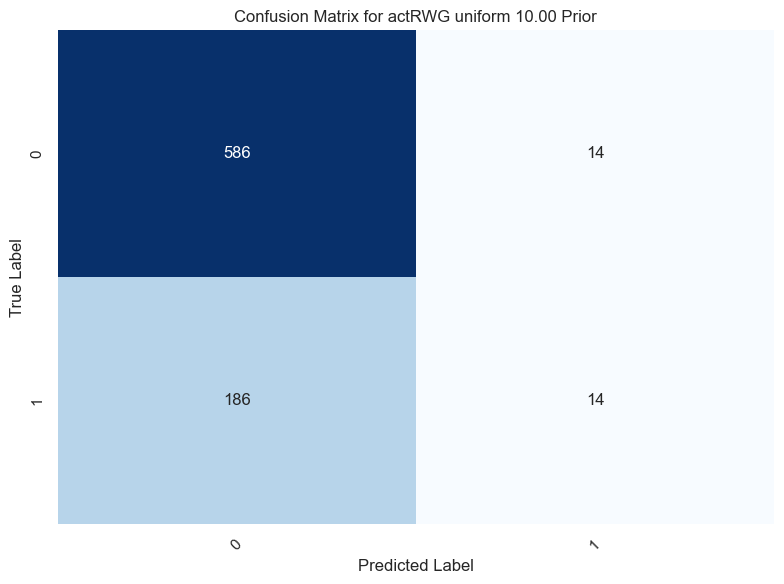

In [107]:
show_cf_matrix(10.0, 'uniform', 'actRWG')

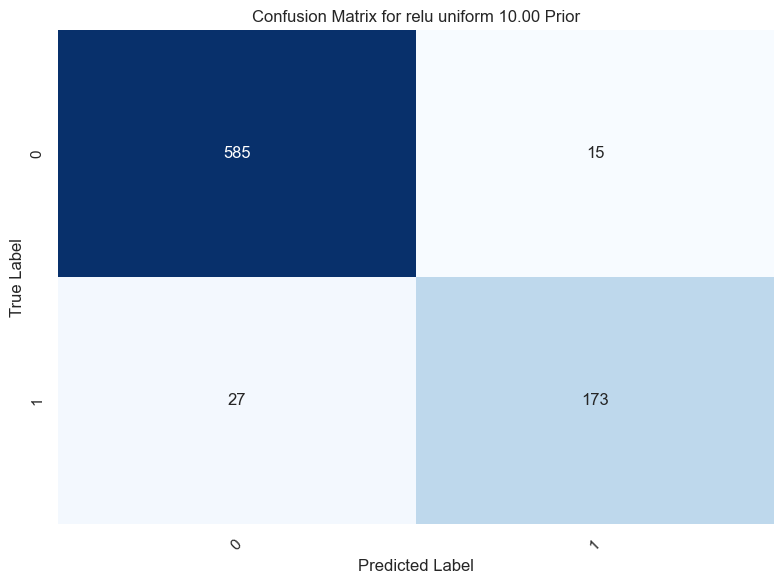

In [108]:
# best test accuracy
show_cf_matrix(10.0, 'uniform', 'relu')

From the confusion matrix, we can see that those with 0.75 accuracy tend to predic for class 0

# Weight and Bias Parameter Distribution

In [109]:
param_files

{'_20250717_030202': 'param_store_actRWG_gaussian_epoch_best_20250717_030202.pkl',
 '_20250717_031000': 'param_store_actRWG_gaussian_epoch_best_20250717_031000.pkl',
 '_20250717_031759': 'param_store_actRWG_gaussian_epoch_best_20250717_031759.pkl',
 '_20250717_060336': 'param_store_actRWG_laplace_epoch_best_20250717_060336.pkl',
 '_20250717_061243': 'param_store_actRWG_laplace_epoch_best_20250717_061243.pkl',
 '_20250717_062137': 'param_store_actRWG_laplace_epoch_best_20250717_062137.pkl',
 '_20250717_091957': 'param_store_actRWG_uniform_epoch_best_20250717_091957.pkl',
 '_20250717_092937': 'param_store_actRWG_uniform_epoch_best_20250717_092937.pkl',
 '_20250717_093915': 'param_store_actRWG_uniform_epoch_best_20250717_093915.pkl',
 '_20250717_023831': 'param_store_actWG_gaussian_epoch_best_20250717_023831.pkl',
 '_20250717_024616': 'param_store_actWG_gaussian_epoch_best_20250717_024616.pkl',
 '_20250717_025412': 'param_store_actWG_gaussian_epoch_best_20250717_025412.pkl',
 '_20250717_0

In [111]:
import pyro

c:\Users\Revalda Putawara\.conda\envs\bnntest\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [162]:
timestamp_target = '_20250717_063037'

merged_df[merged_df['timestamp'] == timestamp_target]

#store the value of the prior, prior_mu, and prior_b
target_prior = merged_df[merged_df['timestamp'] == timestamp_target]['prior'].values[0]
target_prior_mu = merged_df[merged_df['timestamp'] == timestamp_target]['prior_mu'].values[0]
target_prior_b = merged_df[merged_df['timestamp'] == timestamp_target]['prior_b'].values[0]
target_activation = merged_df[merged_df['timestamp'] == timestamp_target]['activation'].values[0]

pyro.get_param_store().set_state(torch.load(os.path.join('results_GP_shipsnet_newslate',param_files[timestamp_target]), weights_only=False))

pyro_parameter_values = {}

for name, value in pyro.get_param_store().items():
    pyro_parameter_values[name.replace("AutoNormal.","")] = value.cpu().detach().numpy()

In [163]:
# create a function to plot the distribution of the parameters
import matplotlib.pyplot as plt
import seaborn as sns

def plot_param_distribution(param_values, param_name, bins, target_activation, target_prior, target_prior_mu, target_prior_b):

    # Extract the parameter values
    values = param_values[param_name]

    #flatten the values if they are multi-dimensional
    if values.ndim > 1:
        values = values.flatten()

    # Plot the distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(values, bins=30, kde=True)
    plt.title(f'Distribution of {param_name}\n Activation: {target_activation}\nPrior: {target_prior}, Prior Mu: {target_prior_mu}, Prior B: {target_prior_b}', fontsize=14)
    plt.xlabel(param_name)
    plt.ylabel('Density')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

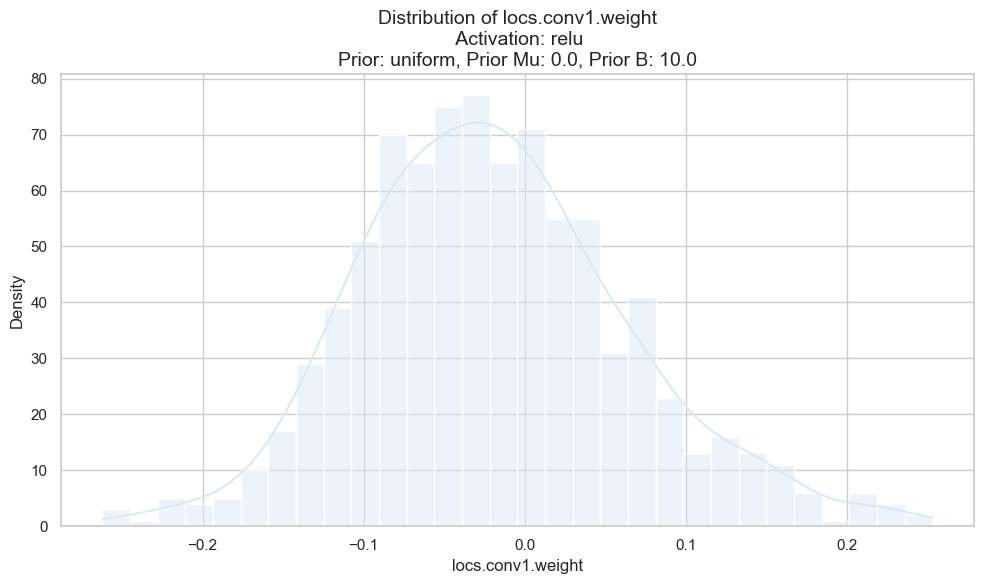

In [173]:
plot_param_distribution(pyro_parameter_values, 
                        "locs.conv1.weight", 
                        30, 
                        target_activation, 
                        target_prior, 
                        target_prior_mu, 
                        target_prior_b)

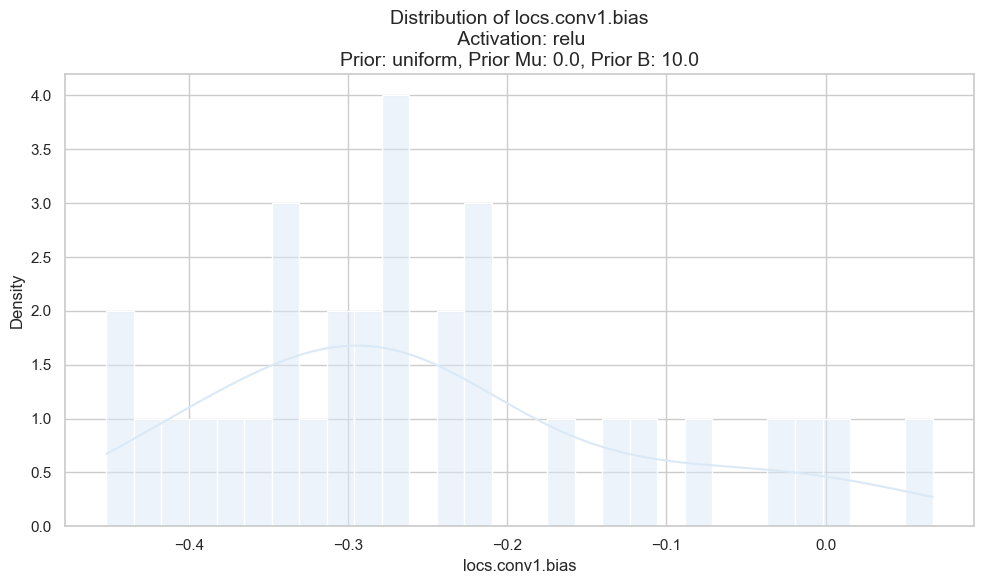

In [174]:
plot_param_distribution(pyro_parameter_values, 
                        "locs.conv1.bias", 
                        30, 
                        target_activation, 
                        target_prior, 
                        target_prior_mu, 
                        target_prior_b)

In [175]:
timestamp_target = '_20250717_032639'

merged_df[merged_df['timestamp'] == timestamp_target]

#store the value of the prior, prior_mu, and prior_b
target_prior = merged_df[merged_df['timestamp'] == timestamp_target]['prior'].values[0]
target_prior_mu = merged_df[merged_df['timestamp'] == timestamp_target]['prior_mu'].values[0]
target_prior_b = merged_df[merged_df['timestamp'] == timestamp_target]['prior_b'].values[0]
target_activation = merged_df[merged_df['timestamp'] == timestamp_target]['activation'].values[0]

pyro.get_param_store().set_state(torch.load(os.path.join('results_GP_shipsnet_newslate',param_files[timestamp_target]), weights_only=False))

pyro_parameter_values = {}

for name, value in pyro.get_param_store().items():
    pyro_parameter_values[name.replace("AutoNormal.","")] = value.cpu().detach().numpy()

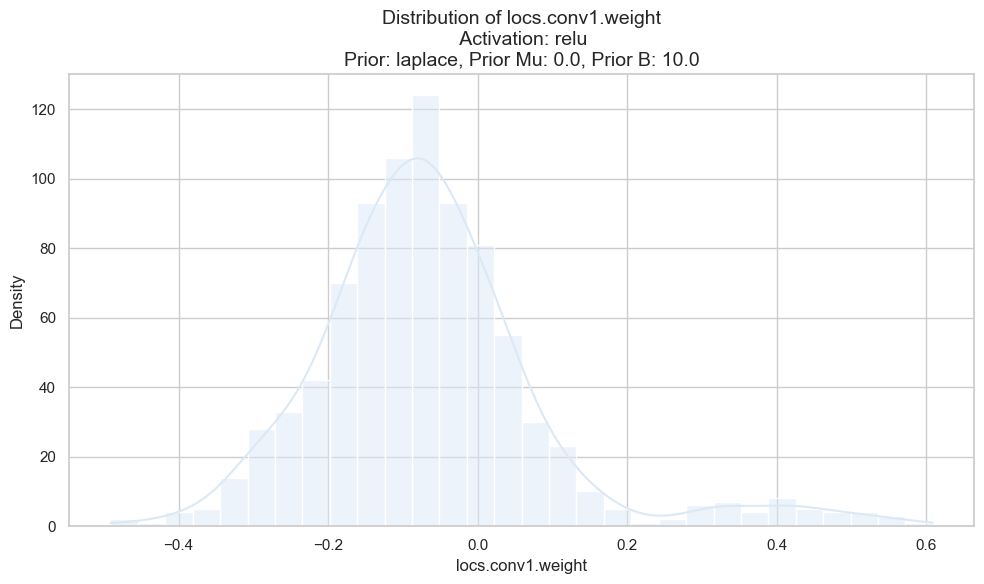

In [176]:
plot_param_distribution(pyro_parameter_values, 
                        "locs.conv1.weight", 
                        30, 
                        target_activation, 
                        target_prior, 
                        target_prior_mu, 
                        target_prior_b)

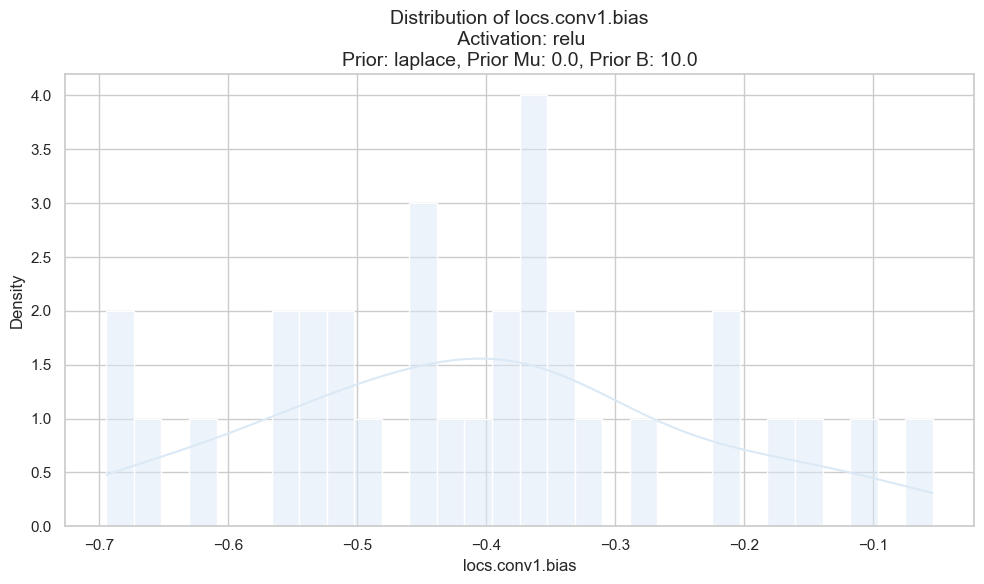

In [177]:
plot_param_distribution(pyro_parameter_values, 
                        "locs.conv1.bias", 
                        30, 
                        target_activation, 
                        target_prior, 
                        target_prior_mu, 
                        target_prior_b)